<a href="https://colab.research.google.com/github/chelynl/Machine_Learning/blob/main/Pipeline_ColumnTransformer_FeatureUnion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Feature Engineering Tools in sklearn**

Resource:<br>
https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f

In [2]:
# Set seed for reproducibility
seed = 123

# Import package/module for data
import pandas as pd
from seaborn import load_dataset

# Import modules for feature engineering and modelling
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

# Load dataset
df = load_dataset('tips').drop(columns=['tip', 'sex']).sample(n=5, random_state=seed)

# Add missing values
df.iloc[[1, 2, 4], [2, 4]] = np.nan
df

,total_bill,smoker,day,time,size
112,38.07,No,Sun,Dinner,3.0
19,20.65,No,NaN,Dinner,NaN
187,30.46,Yes,NaN,Dinner,NaN
169,10.63,Yes,Sat,Dinner,2.0
31,18.35,No,NaN,Dinner,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 112 to 31
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  5 non-null      float64 
 1   smoker      5 non-null      category
 2   day         2 non-null      category
 3   time        5 non-null      category
 4   size        2 non-null      float64 
dtypes: category(3), float64(2)
memory usage: 679.0 bytes


In [8]:
df.isna().sum()

total_bill    0
smoker        0
day           3
time          0
size          3
dtype: int64

In [9]:
df.describe()

,total_bill,size
count,5.000000,2.000000
mean,23.632000,2.500000
std,10.734539,0.707107
min,10.630000,2.000000
25%,18.350000,2.250000
50%,20.650000,2.500000
75%,30.460000,2.750000
max,38.070000,3.000000


Use `'smoker'`, `'day'`, `'time'` columns to predict `'total_bill'`.

In [4]:
# Partition data and drop size column
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['size', 'total_bill']), df['total_bill'],
                                                    test_size=0.2,
                                                    random_state=seed)

We need to impute missing values with a "missing" flag and one-hot encode categorical variables.

In [10]:
"""
Transformation WITHOUT pipeline

Output is:
1 - raw data
2 - output after imputation
3 - output after one-hot encoding
"""

# Impute training data
imputer = SimpleImputer(strategy='constant', fill_value='missing')
X_train_imputed = imputer.fit_transform(X_train)

# Encode training data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded = encoder.fit_transform(X_train_imputed)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(X_train_imputed, columns=X_train.columns))
display(pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names(X_train.columns)))

# Transform test data
X_test_imputed = imputer.transform(X_test)
X_test_encoded = encoder.transform(X_test_imputed)

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(X_test_imputed, columns=X_train.columns))
display(pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names(X_train.columns)))

******************** Training data ********************


,smoker,day,time
169,Yes,Sat,Dinner
31,No,NaN,Dinner
112,No,Sun,Dinner
187,Yes,NaN,Dinner


,smoker,day,time
0,Yes,Sat,Dinner
1,No,missing,Dinner
2,No,Sun,Dinner
3,Yes,missing,Dinner


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner
0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,1.0


******************** Test data ********************


,smoker,day,time
19,No,NaN,Dinner


,smoker,day,time
0,No,missing,Dinner


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner
0,1.0,0.0,0.0,0.0,1.0,1.0


This is all redundant and tedious code... streamline it using a pipeline.
***
# **Pipeline**

In [11]:
# Fit pipeline to training data
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
pipe.fit(X_train)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(pipe.transform(X_train), columns=pipe['encoder'].get_feature_names(X_train.columns)))

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(pipe.transform(X_test), columns=pipe['encoder'].get_feature_names(X_train.columns)))

******************** Training data ********************


,smoker,day,time
169,Yes,Sat,Dinner
31,No,NaN,Dinner
112,No,Sun,Dinner
187,Yes,NaN,Dinner


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner
0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,1.0


******************** Test data ********************


,smoker,day,time
19,No,NaN,Dinner


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner
0,1.0,0.0,0.0,0.0,1.0,1.0


Using a pipeline passes its output to the next step as an input. Therefore, we don’t have to manually keep track of different versions of the data.

In [12]:
"""
Add model to first approach (no pipeline)
"""

# Impute training data
imputer = SimpleImputer(strategy='constant', fill_value='missing')
X_train_imputed = imputer.fit_transform(X_train)

# Encode training data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_encoded = encoder.fit_transform(X_train_imputed)

# Fit model to training data
model = LinearRegression()
model.fit(X_train_encoded, y_train)

# Predict training data
y_train_pred = model.predict(X_train_encoded)
print(f"Predictions on training data: {y_train_pred}")

# Transform test data
X_test_imputed = imputer.transform(X_test)
X_test_encoded = encoder.transform(X_test_imputed)

# Predict test data
y_test_pred = model.predict(X_test_encoded)
print(f"Predictions on test data: {y_test_pred}")

Predictions on training data: [10.63 18.35 38.07 30.46]
Predictions on test data: [18.35]


In [13]:
"""
Add model to pipeline approach
"""

# Fit pipeline to training data
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)), 
    ('model', LinearRegression())
])
pipe.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipe.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")

Predictions on training data: [10.63 18.35 38.07 30.46]
Predictions on test data: [18.35]


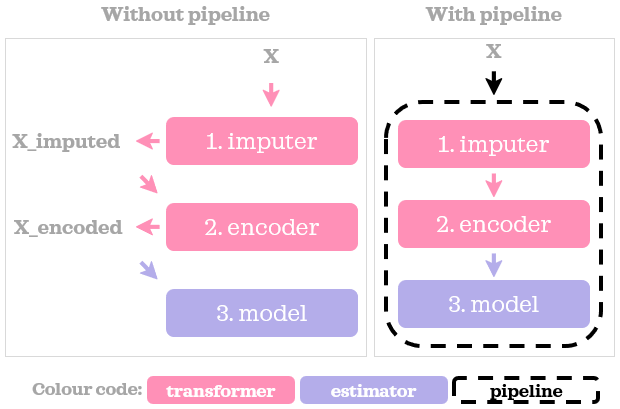

## Benefits of Pipelines:
- organizes and streamlines code
- can fine-tune any parameter of the entire pipeline (both transformers and estimators) with either `GridSearchCV` or `RandomizedSearchCV`
- easier deployment since we are training a single object containing data transformers and a model

***

# **ColumnTransformer()**

Use `ColumnTransformer()` when we need to apply different sets of transformers to different groups of columns.

In [14]:
# Partition data keeping both numeric and categorical vars
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['total_bill']), 
                                                    df['total_bill'], 
                                                    test_size=.2, 
                                                    random_state=seed)

# Define categorical columns
categorical = list(X_train.select_dtypes('category').columns)
print(f"Categorical columns are: {categorical}")

# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['smoker', 'day', 'time']
Numerical columns are: ['size']


We have to split features into groups based on their data type but you can customize this further by splitting categorical variables into multiple groups if different preprocessing pipelines are more suitable for them.

In [15]:
"""
Use ColumnTransformer() with Pipeline 
to transform categorical vars
"""

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Fit column transformer to training data (only affecting categorical vars)
preprocessor = ColumnTransformer([('cat', cat_pipe, categorical)], remainder='passthrough')
preprocessor.fit(X_train)

# Prepare column names
cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names(categorical)
columns = np.append(cat_columns, numerical)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(preprocessor.transform(X_train), columns=columns))

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(preprocessor.transform(X_test), columns=columns))

******************** Training data ********************


,smoker,day,time,size
169,Yes,Sat,Dinner,2.0
31,No,NaN,Dinner,NaN
112,No,Sun,Dinner,3.0
187,Yes,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,0.0,1.0,1.0,0.0,0.0,1.0,2.0
1,1.0,0.0,0.0,0.0,1.0,1.0,NaN
2,1.0,0.0,0.0,1.0,0.0,1.0,3.0
3,0.0,1.0,0.0,0.0,1.0,1.0,NaN


******************** Test data ********************


,smoker,day,time,size
19,No,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,1.0,0.0,0.0,0.0,1.0,1.0,NaN


In [16]:
"""
Use ColumnTransformer() with Pipeline 
to transform both categorical and numeric vars
"""

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # impute missing values with median
    ('scaler', MinMaxScaler())
])

# Fit column transformer to training data
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])
preprocessor.fit(X_train)

# Prepare column names
cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names(categorical)
columns = np.append(cat_columns, numerical)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(preprocessor.transform(X_train), columns=columns))

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(preprocessor.transform(X_test), columns=columns))

******************** Training data ********************


,smoker,day,time,size
169,Yes,Sat,Dinner,2.0
31,No,NaN,Dinner,NaN
112,No,Sun,Dinner,3.0
187,Yes,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.5
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.0,1.0,0.0,0.0,1.0,1.0,0.5


******************** Test data ********************


,smoker,day,time,size
19,No,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,1.0,0.0,0.0,0.0,1.0,1.0,0.5


We applied a different pipeline with different transformers to each group (numeric and categorical) and got results.

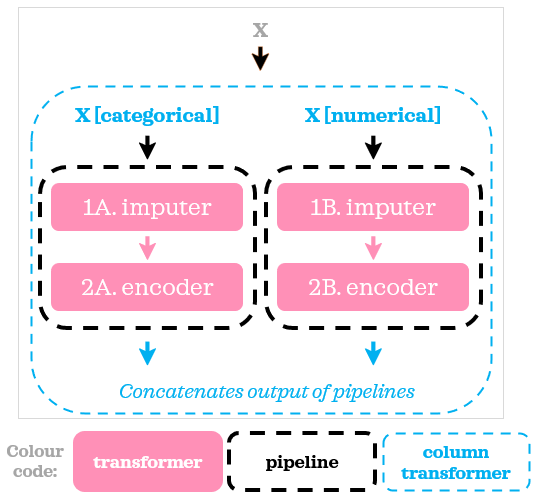

In [17]:
"""
Add model to example
"""

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipe.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")

Predictions on training data: [10.63 18.35 38.07 30.46]
Predictions on test data: [18.35]


Wrap the preprocessing steps and model with another pipeline to combine everything.

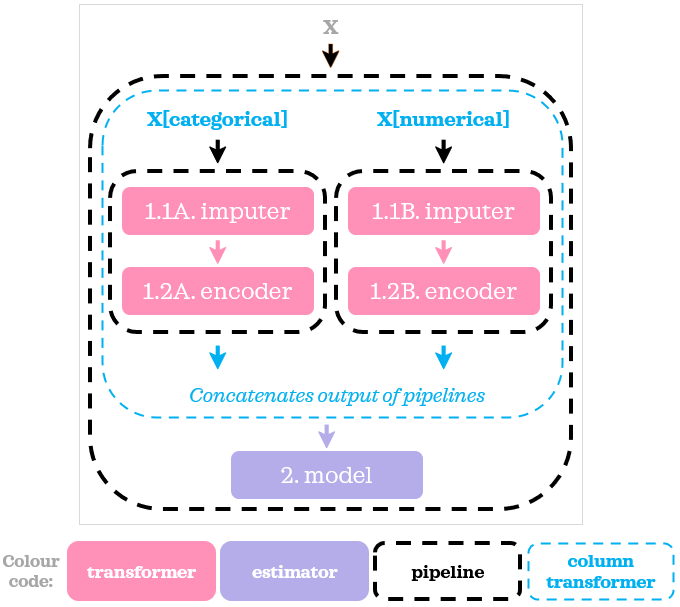

***

# **FeatureUnion**

`FeatureUnion` works like `ColumnTransformer` but much longer way. It creates a copy of the data, transforms those copies in parallel and then outputs the results.

In [18]:
# Define custom transformer
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

# Define categorical pipeline
cat_pipe = Pipeline([
    ('selector', ColumnSelector(categorical)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('selector', ColumnSelector(numerical)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Fit feature union to training data
preprocessor = FeatureUnion([
    ('cat', cat_pipe),
    ('num', num_pipe)
])
preprocessor.fit(X_train)

# Prepare column names
cat_columns = preprocessor.transformer_list[0][1][2].get_feature_names(categorical)
columns = np.append(cat_columns, numerical)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(preprocessor.transform(X_train), columns=columns))

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(preprocessor.transform(X_test), columns=columns))

******************** Training data ********************


,smoker,day,time,size
169,Yes,Sat,Dinner,2.0
31,No,NaN,Dinner,NaN
112,No,Sun,Dinner,3.0
187,Yes,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.5
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0
3,0.0,1.0,0.0,0.0,1.0,1.0,0.5


******************** Test data ********************


,smoker,day,time,size
19,No,NaN,Dinner,NaN


,smoker_No,smoker_Yes,day_Sat,day_Sun,day_missing,time_Dinner,size
0,1.0,0.0,0.0,0.0,1.0,1.0,0.5


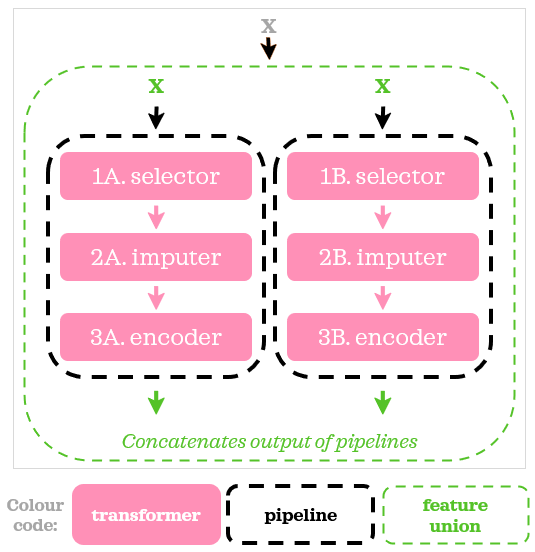

In [19]:
"""
Add model to example
"""

# Define categorical pipeline
cat_pipe = Pipeline([
    ('selector', ColumnSelector(categorical)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('selector', ColumnSelector(numerical)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipeline
preprocessor = FeatureUnion([
    ('cat', cat_pipe),
    ('num', num_pipe)
])

# Combine categorical and numerical pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipe.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")

Predictions on training data: [10.63 18.35 38.07 30.46]
Predictions on test data: [18.35]


When do you use `FeatureUnion` over `ColumnTransformer`?

If you ever need to transform the same input data in different ways and use them as features, `FeatureUnion` is the one. For example, if you are working on a text data and want to do both tf-idf vectorization of the data as well as extract length of text, FeatureUnion is the perfect tool.

***

# Summary

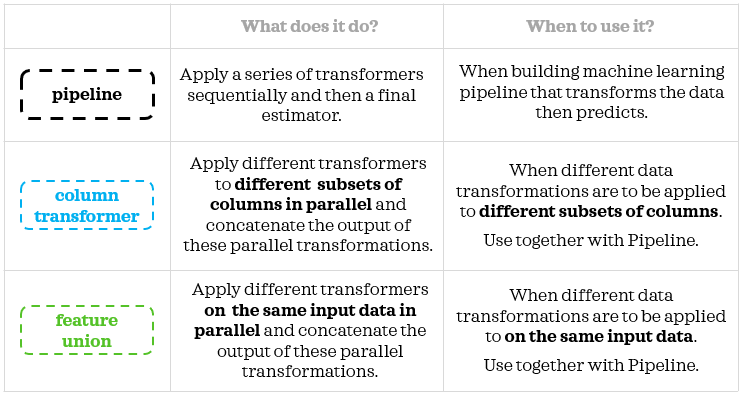